<a href="https://colab.research.google.com/github/OscarRojasG/Experimentos-GPTValidator/blob/main/Framework_Experimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Framework para experimentos GPTValidator

La estructura de carpetas y archivos es la siguiente:

* Datasets
* Miniprompts
  * Ejemplos
  * Contexto
  * Pregunta
  * Respuesta
  * Criteria
  * Reflection
  * Feedback
  * Score
  * Output
* Results

La idea es que los resultados de los experimentos sean guardados en archivos después de cada ejecución.

Para cada experimento se guardarán los siguientes datos:
* Nombre del dataset
* Fecha de ejecución
* Datos por iteración:
  * Puntajes asignados
  * Métricas obtenidas (MSE, RMSE, R^2)
* Resumen de métricas (Media, Desviación estándar)

# Framework para experimentos

In [1]:
!pip install openai==0.28 &> /dev/null
!pip install openai-multi-client &> /dev/null
!git clone https://github.com/rilianx/GPTEvaluator &> /dev/null

!curl -LO https://raw.githubusercontent.com/OscarRojasG/Experimentos-GPTValidator/main/Experiments.zip &> /dev/null
!unzip -n Experiments.zip &> /dev/null

In [2]:
from scipy.optimize import differential_evolution
import numpy as np

gpt_dicts = [
    {
        'relevance': 10,
        'clarity': 8,
        'precision': 7
    },
    {
        'relevance': 3,
        'clarity': 6,
        'precision': 4
    }
]

real_scores = [3, 2]
criteria = ['relevance', 'clarity', 'precision']

# Función para cálculo de puntajes
def f(x, theta):
    score = np.dot(x, theta[:-3])
    y_pred = np.where(score > theta[-3], 3, np.where(score > theta[-2], 2, np.where(score > theta[-1], 1, 0)))
    return y_pred

# Definir la función de error MSE con penalización por restricciones
def mse_with_penalty(theta, x, y):
    y_pred = f(x, theta)
    mse = np.mean((y - y_pred) ** 2)

    # Penalización por violación de restricciones
    penalty = 1e6 * np.abs(np.sum(theta[:-3]) - 1)  # Penalización grande si la suma de ponderaciones no es 1

    return mse + penalty

# Calcular puntajes finales a partir de puntajes GPT, optimizando ponderaciones y cortes
def get_gpt_scores(gpt_dicts, real_scores, criteria):
    w_bounds = [(0, 1) for _ in range(len(criteria))]

    c_bounds = [(7, 10), (4, 7), (1, 4)]
    bounds = w_bounds + c_bounds

    x = [
        [gpt_dict[key] for key in criteria]
        for gpt_dict in gpt_dicts
    ]
    result = differential_evolution(mse_with_penalty, bounds, args=(x, real_scores), seed=1, strategy='rand1exp')

    gpt_scores = f(x, result.x).tolist()
    params = result.x.tolist()
    params = [round(p, 2) for p in params]
    weights = dict(zip(criteria, params[:-3]))
    cuts = params[-3:]

    return gpt_scores, weights, cuts

get_gpt_scores(gpt_dicts, real_scores, criteria)

([3, 2],
 {'relevance': 0.04, 'clarity': 0.88, 'precision': 0.09},
 [7.69, 4.21, 2.87])

In [16]:
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report, r2_score, accuracy_score
from GPTEvaluator.GPTEvaluator import chat_gpt_multiple
from openai_multi_client import OpenAIMultiClient
from datetime import datetime, timedelta
from google.colab import userdata
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import openai
import getpass
import json
import copy
import re
import os

openai.api_key = userdata.get('api_key')

# Retorna un diccionario con el contenido de cada miniprompt
def read_miniprompts(data):
    def read_file(folder, filename):
        path = f"Experiments/Miniprompts/{folder}/{filename}"
        try:
            return open(path, 'r', encoding='utf-8').read()
        except:
            raise Exception(f"Error: El archivo {path} no existe")

    mdata = copy.deepcopy(data)
    for i, (key, value) in enumerate(data.items()):
        if key == "instructions":
            for j, (key2, value2) in enumerate(data[key].items()):
                mdata[key][key2] = read_file(key2, value2)
        else:
            mdata[key] = read_file(key, value)

    return mdata

# Genera un prompt a partir de un diccionario con el contenido de cada miniprompt
def generate_prompt(data):
    prompt = ""
    n = len(data.items())

    for i, (key, value) in enumerate(data.items()):
        if key == "instructions":
            prompt += "Instructions: \n"
            for j, (key2, value2) in enumerate(data[key].items()):
                prompt += value2 + "\n\n"
        else:
            prompt += value
            if i < n-1:
                prompt += "\n\n"

    return prompt

# Carga un dataset a partir de un archivo xlsx y valida sus columnas
def load_dataset(filename, column_data):
  path = f"Experiments/Datasets/{filename}"
  df = pd.read_excel(path)

  mandatory_cols = ["context", "question", "answer", "real_eval"]
  for key in mandatory_cols:
    if key not in column_data.keys():
      raise Exception(f"Error: Debe especificar la columna para la variable {key}")

    value = column_data[key]
    if value not in df.columns:
      raise Exception(f"Error: La columna {value} no existe")

    df = df.rename(columns={value: key})

  return df

# Genera las respuestas con ChatGPT
def eval_gpt(df, prompt):
  api = OpenAIMultiClient(endpoint="chats", data_template={"model": "gpt-3.5-turbo", "temperature": 0.2, "n": 1, "timeout":10}, concurrency=50, wait_interval=1, max_retries=3, retry_max=10, retry_multiplier=1)

  texts = []
  for i, row in df.iterrows():
    text = prompt.format(Question=row['question'], Answer=row['answer'], Context=row['context'])
    texts.append(text)

  answers_gpt = chat_gpt_multiple(api, texts)
  return answers_gpt

# Convierte la respuesta de GPT en un diccionario
def get_gpt_dicts(answers_gpt):
    pattern = r'\{[^{}]+\}'

    gpt_dicts = []
    for answer_gpt in answers_gpt:
        try:
            answer = re.findall(pattern, answer_gpt[0])[0]
            gpt_dicts.append(eval(answer))
        except Exception as e:
            print(f"Error al extraer diccionario. Respuesta GPT: \n{answer_gpt[0]}\n\n")
            gpt_dicts.append(None)

    return gpt_dicts

# Obtiene los puntajes reales de un dataset
def get_real_scores(df):
    return df['real_eval'].tolist()

# Calcula las métricas de evaluación
def get_stats(real_scores, gpt_scores):
  stats = {
      "confusion_matrix": confusion_matrix(real_scores, gpt_scores, labels=[0,1,2,3]).tolist(),
      "mse": mean_squared_error(real_scores, gpt_scores),
      "mae": mean_absolute_error(real_scores, gpt_scores),
      "r2": r2_score(real_scores, gpt_scores),
      "accuracy": accuracy_score(real_scores, gpt_scores),
      "sample_size": len(real_scores)
  }
  return stats

def save_results(dataset, dataset_size, prompt, results, filepath):
  with open(filepath, 'w', encoding='utf-8') as file:
    data = {
        "dataset_name": dataset,
        "dataset_size": dataset_size,
        "prompt": prompt['prompt'],
        "field": prompt['field'],
        "file": prompt['file'],
        "results": results
    }
    json.dump(data, file, ensure_ascii=False)

def remove_invalid_samples(gpt_dicts, real_scores):
    for i in reversed(range(len(gpt_dicts))):
        if gpt_dicts[i] == None:
            gpt_dicts.pop(i)
            real_scores.pop(i)

# Evalúa un prompt y retorna las estadísticas obtenidas
def evaluate_prompt(df, prompt, criteria):
    try:
        answers_gpt = eval_gpt(df, prompt)
        real_scores = get_real_scores(df)
        gpt_dicts = get_gpt_dicts(answers_gpt)
        remove_invalid_samples(gpt_dicts, real_scores)
        gpt_scores, weights, cuts = get_gpt_scores(gpt_dicts, real_scores, criteria)
        stats = get_stats(real_scores, gpt_scores)

        return {
            'params': {
                'weights': weights,
                'cuts': cuts
            },
            'stats': stats
        }
    except Exception as e:
        print(e)

# Evalúa un prompt para N repeticiones
def evaluate_prompt_n(df, prompt, criteria, repetitions):
    result_list = []

    for _ in range(repetitions):
        result = evaluate_prompt(df, prompt, criteria)
        result_list.append(result)

    return result_list

# Retorna una lista con la metadata necesaria para generar cada prompt
def transform_prompt_data(prompt_data):
    folder_key = None
    instruction = False
    update_count = 0

    for key, value in prompt_data.items():
        if key == "instructions":
            for key2, value2 in prompt_data[key].items():
                if value2 == "*":
                    folder_key = key2
                    instruction = True
                    update_count += 1

        elif value == "*":
            folder_key = key
            update_count += 1

    if update_count == 0: # Sin carpetas, evaluar archivos directamente
        return [{'data': prompt_data, 'field': None, 'file': None}]
    elif update_count > 1:
        raise Exception(f"Error: Solo una carpeta a la vez como máximo")

    # Recorrer archivos en la carpeta y generar lista de metadatos
    prompt_data_list = []
    path = f"Experiments/Miniprompts/{folder_key}"
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            prompt_data_copy = copy.deepcopy(prompt_data)
            if instruction:
                prompt_data_copy["instructions"][folder_key] = file
            else:
                prompt_data_copy[folder_key] = file

            prompt_data_list.append({'data': prompt_data_copy, 'field_in_instructions': instruction, 'field': folder_key, 'file': file})

    return prompt_data_list

# Genera los prompts a partir de un objeto prompt_data
def generate_prompts(prompt_data):
    prompt_data_list = transform_prompt_data(prompt_data)

    for prompt_data in prompt_data_list:
        miniprompt_data = read_miniprompts(prompt_data['data'])
        prompt_data['prompt'] = generate_prompt(miniprompt_data)

    return prompt_data_list

# Muestra un histograma a partir de la frecuencia de puntajes
def show_histogram(real_counts, pred_counts):
    bins = np.arange(-0.5, 4, 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    width = 0.35
    plt.bar(bin_centers - width/2, real_counts, width=width, label='Real Eval', align='center')
    plt.bar(bin_centers + width/2, pred_counts, width=width, label='GPT Eval', align='center')

    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    plt.title('Histograma')
    plt.legend()
    plt.show()

# Muestra resultados del experimento
def show_results(dir):
    print(f"{'':<20} {'Métrica':<15} {'Media':<15} Desviación estándar\n")
    for filename in sorted(os.listdir(dir)):
        path = os.path.join(dir, filename)
        if os.path.isfile(path):
            file = open(path, 'r', encoding='utf-8')
            data = json.load(file)
            file.close()

            maes = []
            mses = []
            r2s = []
            accuracies = []
            matrices = []

            for result in data['results']:
                stats = result['stats']
                maes.append(stats['mae'])
                mses.append(stats['mse'])
                r2s.append(stats['r2'])
                accuracies.append(stats['accuracy'])
                matrices.append(stats['confusion_matrix'])

            prompt_file = data['file']
            if prompt_file == None: prompt_file = "Prompt"

            print(f"{f'{prompt_file}':<20} {'MAE':<15} {round(np.mean(maes),3):<15} {round(np.std(maes),3):<15}")
            print(f"{'':<20} {'MSE':<15} {round(np.mean(mses),3):<15} {round(np.std(mses),3):<15}")
            print(f"{'':<20} {'R2':<15} {round(np.mean(r2s),3):<15} {round(np.std(r2s),3):<15}")
            print(f"{'':<20} {'Accuracy':<15} {round(np.mean(accuracies),3):<15} {round(np.std(accuracies),3):<15}\n")

            matrices_np = np.array(matrices)
            matrix_sum = np.sum(matrices_np, axis=0)
            formatted_matrix_sum = str(matrix_sum).split('\n')
            print(f"{'':<20} {'Matriz confusión'}")
            for row in formatted_matrix_sum:
                print(f"{'':<20} {row}")
            print()

            real_counts = [sum(row) for row in matrix_sum]
            pred_counts = [sum(col) for col in list(zip(*matrix_sum))]
            show_histogram(real_counts, pred_counts)
            print()


# Evalúa varios prompts a la vez con N repeticiones
def experiment(dataset, column_data, prompt_data, criteria, repetitions):
    def create_dir():
        date = datetime.now() - timedelta(hours=4)
        formatted_date = date.strftime('%Y%m%d-%H%M')

        dir = f"Experiments/Results/{formatted_date}"
        if not os.path.exists(dir):
            os.makedirs(dir)
        return dir

    visualize_prompt(prompt_data)

    df = load_dataset(dataset, column_data)
    prompts = generate_prompts(prompt_data)
    dir = create_dir()

    for i, prompt in enumerate(prompts):
        if prompt['file']:
            filename = os.path.splitext(prompt['file'])[0]
        else:
            filename = "results"

        filepath = f"{dir}/{filename}.json"
        result_list = evaluate_prompt_n(df, prompt['prompt'], criteria, repetitions)
        save_results(dataset, len(df), prompt, result_list, filepath)

    print('\n')
    show_results(dir)

# Muestra el prompt generado a partir de un diccionario prompt_data
def visualize_prompt(prompt_data):
    prompt_data_list = transform_prompt_data(prompt_data)
    miniprompt_data = read_miniprompts(prompt_data_list[0]['data'])

    if len(prompt_data_list) == 1:
        print(generate_prompt(miniprompt_data))
    else:
        prompt_data = prompt_data_list[0]
        if prompt_data['field_in_instructions']:
            miniprompt_data['instructions'][prompt_data['field']] = f"{{{prompt_data['field']}}}"
        else:
            miniprompt_data[prompt_data['field']] = f"{{{prompt_data['field']}}}"
        print(generate_prompt(miniprompt_data))


{examples}

**Context (not visible to students):** {Context}

**Question:** {Question}

**Student's Answer:** {Answer}

Instructions: 
(analysis)
Analyse the "Student's Answer".
Start by paraphrasing the answer in detail and commenting each sentence.
It rewrites the same information provided in the question? or It correctly answers the question providing relevant and deep new information?
It is complete, that is, answers all the questions?
Use the hidden context as a reference to validate the accuracy and relevance of the student's response.
Focus on the alignment between the question asked and the answer provided.

(feedback)
Provide Feedback to the student considering the analysis. **Do not be strict at all**.
It is enough that the student answer correctly and more or less completely the question. **Do not ask for additional information**.
Start by stating whether the answer is good/excelent or poor/insatisfactory.
If the answer is good/excelent, affirm the student's understanding an

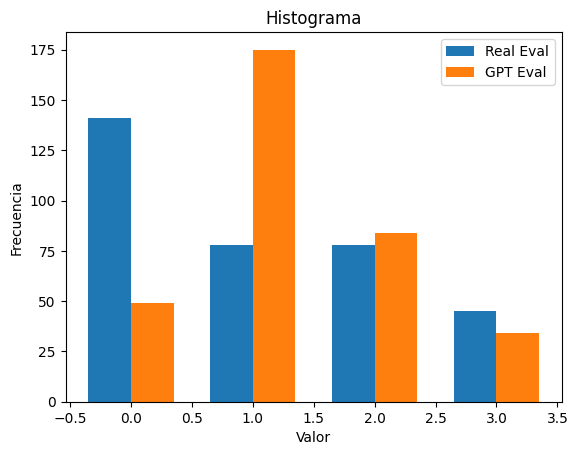


examples_2.txt       MAE             0.673           0.03           
                     MSE             0.871           0.05           
                     R2              0.249           0.043          
                     Accuracy        0.427           0.048          

                     Matriz confusión
                     [[40 78 23  0]
                      [15 54  8  1]
                      [ 1 33 38  6]
                      [ 0  9 22 14]]



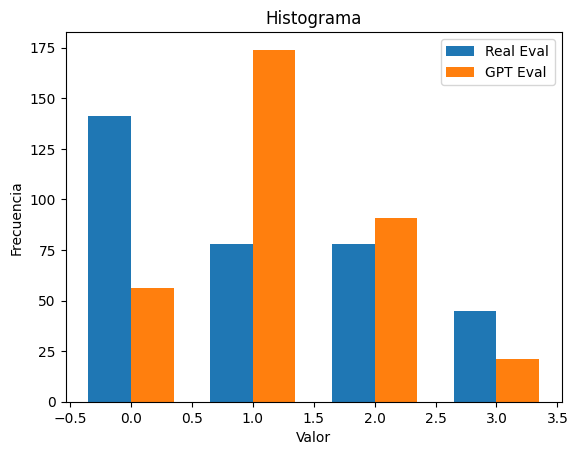


examples_3.txt       MAE             0.687           0.027          
                     MSE             0.868           0.061          
                     R2              0.252           0.053          
                     Accuracy        0.401           0.015          

                     Matriz confusión
                     [[39 84 17  1]
                      [15 54  8  1]
                      [ 0 38 31  9]
                      [ 0 10 22 13]]



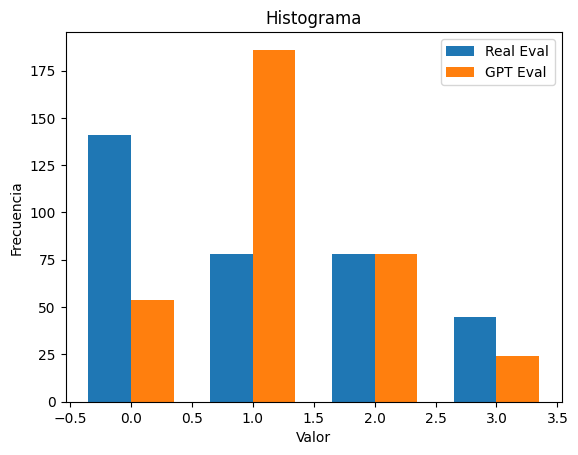

In [17]:
prompt_data = {
    "examples": "*",
    "context": "context_1.txt",
    "question": "question_1.txt",
    "answer": "answer_1.txt",
    "instructions": {
        "reflection": "reflection_1.txt",
        "feedback": "feedback_1.txt",
        "score": "score_1.txt",
    },
    "criteria": "criteria_1.txt",
    "output": "output_1.txt"
}

column_data = {
    "context": "Contexto",
    "question": "Pregunta",
    "answer": "Respuesta",
    "real_eval": "EvalProfe"
}

criteria = ["correctness", "completeness", "clarity"]

#visualize_prompt(prompt_data)
experiment("control2_2024-1.xlsx", column_data, prompt_data, criteria, repetitions=3)

In [18]:
# Descargar carpeta
!zip -r Experiments.zip Experiments/

from google.colab import files
files.download("/content/Experiments.zip")

updating: Experiments/Datasets/ (stored 0%)
updating: Experiments/Datasets/control2_2024-1.xlsx (deflated 6%)
updating: Experiments/Datasets/test.xlsx (deflated 22%)
updating: Experiments/Miniprompts/ (stored 0%)
updating: Experiments/Miniprompts/answer/ (stored 0%)
updating: Experiments/Miniprompts/answer/answer_1.txt (deflated 10%)
updating: Experiments/Miniprompts/context/ (stored 0%)
updating: Experiments/Miniprompts/context/context_1.txt (deflated 6%)
updating: Experiments/Miniprompts/criteria/ (stored 0%)
updating: Experiments/Miniprompts/criteria/criteria_1.txt (deflated 12%)
updating: Experiments/Miniprompts/examples/ (stored 0%)
updating: Experiments/Miniprompts/examples/examples_1.txt (deflated 50%)
updating: Experiments/Miniprompts/examples/examples_2.txt (deflated 48%)
updating: Experiments/Miniprompts/feedback/ (stored 0%)
updating: Experiments/Miniprompts/feedback/feedback_1.txt (deflated 45%)
updating: Experiments/Miniprompts/output/ (stored 0%)
updating: Experiments/Min

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>